In [2]:
import sys
sys.version

'2.7.14 |Anaconda, Inc.| (default, Oct 16 2017, 17:29:19) \n[GCC 7.2.0]'

In [3]:
import sys, traceback
import argparse
import string
import cv2
import numpy as np
LIBRARY_PATH = '/home/iizuka/workspace/py2/lib'
PLANTCV_PATH = '/home/iizuka/workspace/py2/lib/plantcv'
sys.path.append(LIBRARY_PATH)
sys.path.append(PLANTCV_PATH)
import plantcv as pcv
from database_manipulator import EnvironmentalDatabaseManipulator
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
#IMG_DATABASE_PATH = "/home/iizuka/ImageDatabase/aerial_image"
IMG_DATABASE_PATH = "/home/iizuka/workspace/py2/input_imgs"


In [4]:

img_file = IMG_DATABASE_PATH + '/1511513007.jpg'
img, path, filename = pcv.readimage(img_file)

In [5]:
pcv.__file__


'/home/iizuka/workspace/py2/lib/plantcv/plantcv/__init__.pyc'

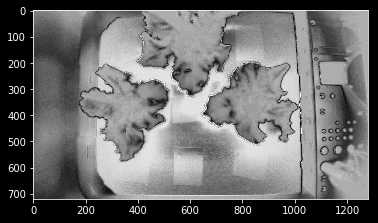

In [69]:
# Convert RGB to HSV and extract the Saturation channel
device = 0
debug = 'plot'
device,img=pcv.white_balance(device,img,debug,roi=(50,0,1000,600))
device, s = pcv.rgb2gray_hsv(img, 's', device, debug)

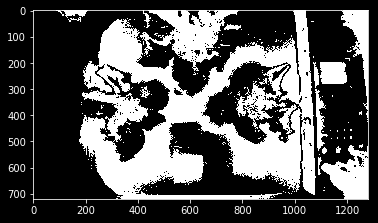

In [70]:
# Threshold the Saturation image
device, s_thresh = pcv.binary_threshold(s, 155, 255, 'light', device, debug)

In [71]:
print(device)

3


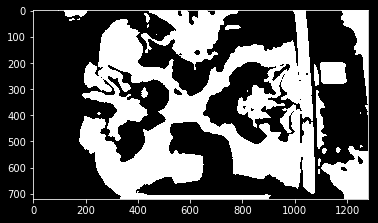

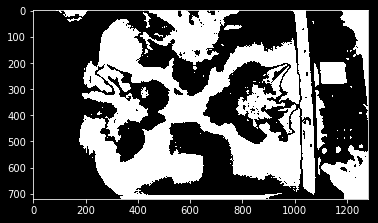

In [72]:
# Median Filter
device, s_mblur = pcv.median_blur(s_thresh, 13, device, debug)
device, s_cnt = pcv.median_blur(s_thresh, 5, device, debug)

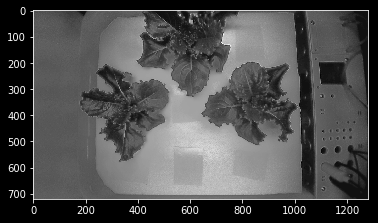

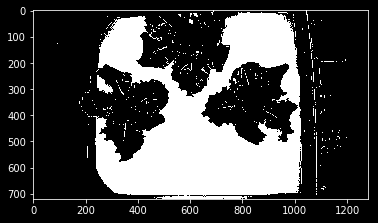

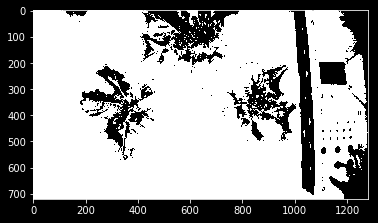

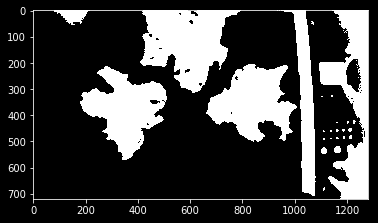

In [73]:
# Convert RGB to LAB and extract the Blue channel
device, l = pcv.rgb2gray_lab(img, 'l', device, debug)

# Threshold the blue image
device, l_thresh = pcv.binary_threshold(l, 100, 255, 'light', device, debug)
device, l_cnt = pcv.binary_threshold(l, 60, 255, 'light', device, debug)

# Fill small objects
device, b_fill = pcv.fill(b_thresh, b_cnt, 10, device, debug)

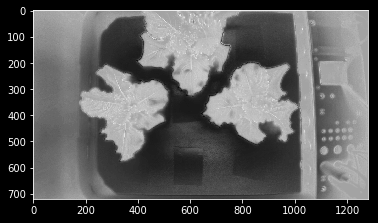

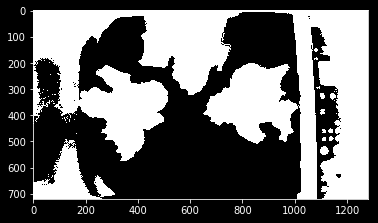

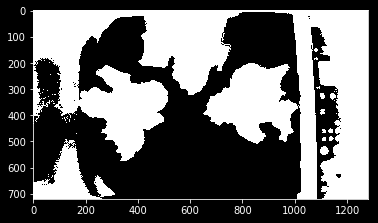

In [74]:
# Convert RGB to LAB and extract the Blue channel
device, b = pcv.rgb2gray_lab(img, 'b', device, debug)

# Threshold the blue image
device, b_thresh = pcv.binary_threshold(b, 110, 255, 'light', device, debug)
device, b_cnt = pcv.binary_threshold(b, 110, 255, 'light', device, debug)

# Fill small objects
#device, b_fill = pcv.fill(b_thresh, b_cnt, 10, device, debug)

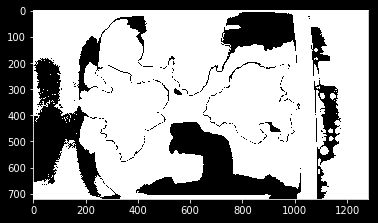

In [75]:
# Join the thresholded saturation and blue-yellow images
device, bs = pcv.logical_or(s_mblur, b_cnt, device, debug)

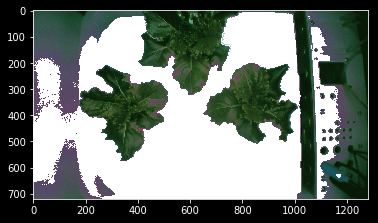

In [111]:
# Apply Mask (for vis images, mask_color=white)
device, masked = pcv.apply_mask(img, b_cnt, 'white', device, debug)

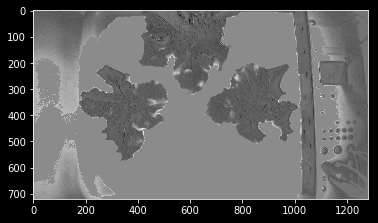

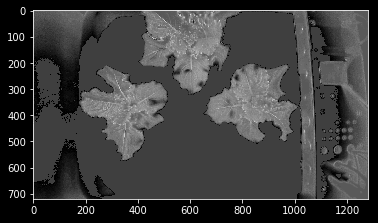

In [112]:
# Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
device, masked_a = pcv.rgb2gray_lab(masked, 'a', device, debug)
device, masked_b = pcv.rgb2gray_lab(masked, 'b', device, debug)

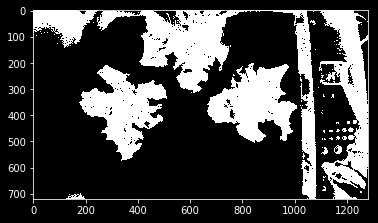

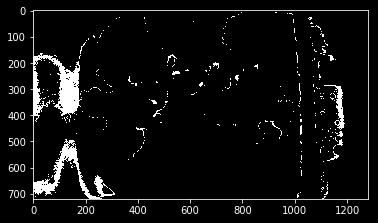

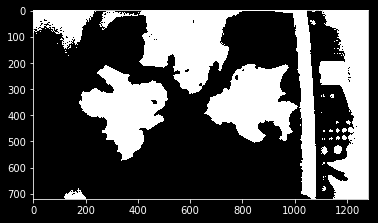

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ..., 
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)

In [127]:

# Threshold the green-magenta and blue images
device, maskeda_thresh = pcv.binary_threshold(masked_a, 115, 255, 'dark', device, debug)
device, maskeda_thresh1 = pcv.binary_threshold(masked_a, 135, 255, 'light', device, debug)
device, maskedb_thresh = pcv.binary_threshold(masked_b, 128, 255, 'light', device, debug)

maskedb_thresh

(720, 1280)

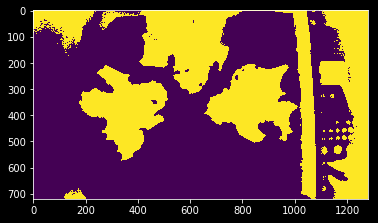

In [129]:
plt.imshow(maskedb_thresh)
maskedb_thresh.shape

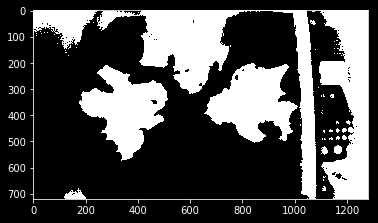

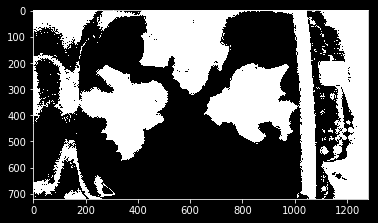

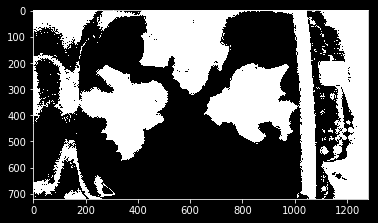

In [123]:
# Join the thresholded saturation and blue-yellow images (OR)
device, ab1 = pcv.logical_or(maskeda_thresh, maskedb_thresh, device, debug)
device, ab = pcv.logical_or(maskeda_thresh1, ab1, device, debug)
device, ab_cnt = pcv.logical_or(maskeda_thresh1, ab1, device, debug)


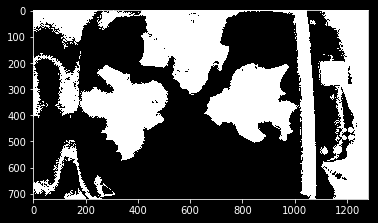

In [124]:
# Fill small objects
device, ab_fill = pcv.fill(ab, ab_cnt, 200, device, debug)


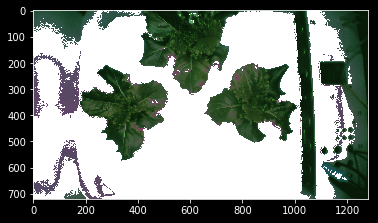

shape of masked2 and masked, ab_fill is (720, 1280, 3) and (720, 1280, 3), (720, 1280)


In [171]:

# Apply mask (for vis images, mask_color=white)
device, masked2 = pcv.apply_mask(masked, ab_fill, 'white', device, debug)
print('shape of masked2 and masked, ab_fill is {} and {}, {}'.format(masked2.shape, masked.shape, ab_fill.shape))

In [137]:
print('ab_fill shape{}'.format(ab_fill.shape))
print('maskedb_thresh shape{}'.format(maskedb_thresh.shape))

ab_fill shape(720, 1280)
maskedb_thresh shape(720, 1280)


In [78]:
len(roi_objects)
roi_objects[0].shape


(1, 1, 2)

(720, 1280, 3)

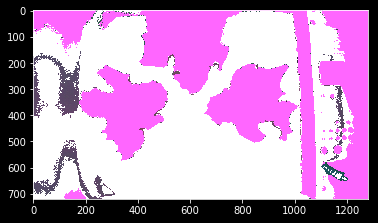

In [142]:
device, id_objects,obj_hierarchy = pcv.find_objects(masked2, maskedb_thresh, device, debug)


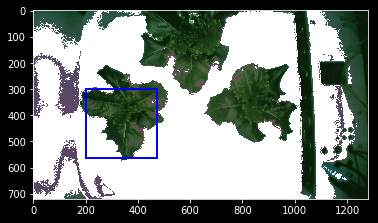

In [143]:
device, roi1, roi_hierarchy= pcv.define_roi(masked2, 'rectangle', device, None, 'default', debug, True, 200, 300, -800, -150)

In [146]:
roi_hierarchy

array([[[-1, -1,  1, -1],
        [-1, -1, -1,  0]]], dtype=int32)

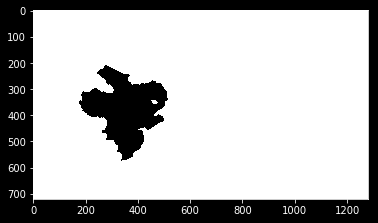

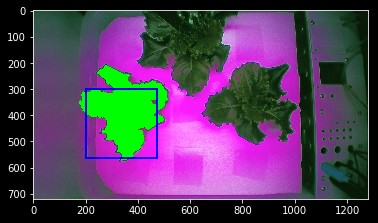

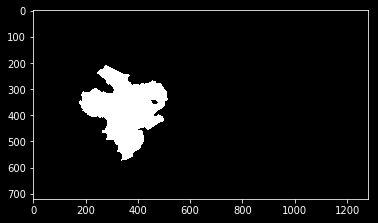

In [147]:
device,roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img, 'partial', roi1, roi_hierarchy, id_objects, obj_hierarchy, device, debug)

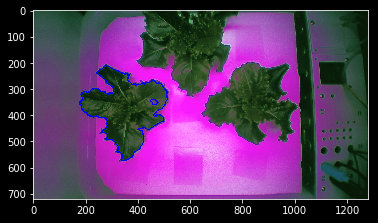

In [148]:
device, obj, mask = pcv.object_composition(img, roi_objects, hierarchy3, device, debug)

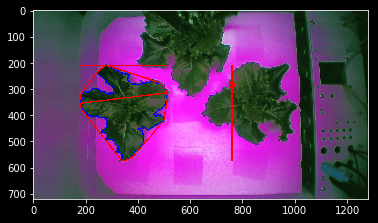

In [149]:
device, shape_header, shape_data, shape_img = pcv.analyze_object(img, 'hoge.jpg', obj, maskedb_thresh, device, debug, args.outdir + '/' + filename)

In [169]:
shape_data
def get_shapedata_dict(shape_data):
    SHAPES_PROPERTIES = (
        'name',
        'object_area',
         'convex-hull_area',
         'solidity',
         'object_perimeter_length',
         'object_width_(extent_x)',
         'object_height_(extent_y)',
         'longest_axis',
         'center_of_mass-x',
         'center_of_mass-y',
         'hull_vertices',
         'in_bounds',
         'object_bounding_ellipse_center-x',
         'object_bounding_ellipse_center-y',
         'object_bounding_ellipse_major_axis',
         'object_bounding_ellipse_minor_axis',
         'object_bounding_ellipse_angle',
         'object_bounding_ellipse_eccentricity'
    )
    print('shape_data length : {}, shape_prop length : {}'.format(len(shape_data), len(shape_properties)))
    if len(shape_data) == len(SHAPES_PROPERTIES):
        shape_dict = {prop:shape_data[i] for i, prop in enumerate(SHAPES_PROPERTIES)}
        return shape_dict
    else:
        print('length of shape data is not compatible')
hoge = get_shapedata_dict(shape_data)
hoge

shape_data length : 18, shape_prop length : 18


{'center_of_mass-x': 760.235624882974,
 'center_of_mass-y': 285.8093678434084,
 'convex-hull_area': 78320.0,
 'hull_vertices': 27,
 'in_bounds': True,
 'longest_axis': 336,
 'name': 'SHAPES_DATA',
 'object_area': 347145.0,
 'object_bounding_ellipse_angle': 160.86521911621094,
 'object_bounding_ellipse_center-x': 349.57635498046875,
 'object_bounding_ellipse_center-y': 379.1038513183594,
 'object_bounding_ellipse_eccentricity': 0.33772164119259163,
 'object_bounding_ellipse_major_axis': 312.3895568847656,
 'object_bounding_ellipse_minor_axis': 294.0354309082031,
 'object_height_(extent_y)': 364,
 'object_perimeter_length': 2162.5029628276825,
 'object_width_(extent_x)': 337,
 'solidity': 4.432392747701736}

In [163]:
print(shape_data[1:])

[347145.0, 78320.0, 4.432392747701736, 2162.5029628276825, 337, 364, 336, 760.235624882974, 285.8093678434084, 27, True, 349.57635498046875, 379.1038513183594, 312.3895568847656, 294.0354309082031, 160.86521911621094, 0.33772164119259163]


In [150]:
shape_img

[['IMAGE',
  'shapes',
  '/home/iizuka/workspace/py2/generated_imgs/plantcv/1511513007_shapes.jpg'],
 ['IMAGE',
  'mask',
  '/home/iizuka/workspace/py2/generated_imgs/plantcv/1511513007_mask.jpg']]

In [101]:
id_objects[0].shape

(1, 1, 2)

In [141]:

print('length of id_objects is {}'.format(len(id_objects)))
for i, obj in enumerate(id_objects):
    area = cv2.contourArea(obj)
    if area > 4000:
        print(i, area)
#obj = id_objects[641]

length of id_objects is 811
(161, 61763.5)
(178, 61585.0)
(373, 79249.5)
(513, 112202.0)
(622, 18929.0)


In [85]:
class Args():
    def __init__(self, **kwargs):
        self.image = kwargs['image']
        self.outdir = kwargs['outdir']
        self.names = kwargs['names']
        self.debug = kwargs['debug']
        self.writeimg = kwargs['writeimg']
        self.result = kwargs['result']

IMG_DATABASE_PATH = '/home/iizuka/workspace/py2/input_imgs'
img_file = IMG_DATABASE_PATH + '/1511513007.jpg'
out_dir = '/home/iizuka/workspace/py2/generated_imgs/plantcv'

kwargs = {
    'image':img_file,
    'outdir':out_dir,
    'names':'',
    'debug':'plot',
    'result':'result.jpg',
    'writeimg':True
    
}
args = Args(**kwargs)

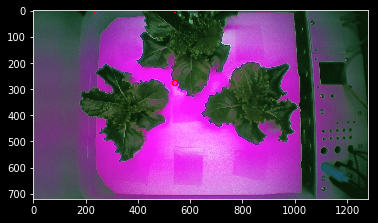

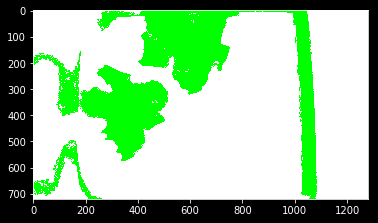

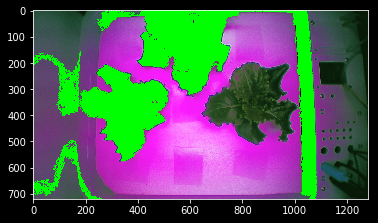

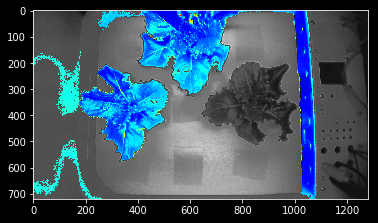

In [119]:
outfile=False
if args.writeimg==True:
    outfile=args.outdir+"/"+filename

# Find shape properties, output shape image (optional)
device, shape_header, shape_data, shape_img = pcv.analyze_object(img, args.image, obj, mask, device, debug, args.outdir + '/' + filename)

# Shape properties relative to user boundary line (optional)
device, boundary_header, boundary_data, boundary_img1 = pcv.analyze_bound(img, args.image, obj, mask, 1680, device, debug, args.outdir + '/' + filename)

# Determine color properties: Histograms, Color Slices and Pseudocolored Images, output color analyzed images (optional)
device, color_header, color_data, color_img = pcv.analyze_color(img, args.image, kept_mask, 256, device, debug, 'all', 'v', 'img', 300, args.outdir + '/' + filename)

# Write shape and color data to results file
result=open(args.result,"a")
result.write('\t'.join(map(str,shape_header)))
result.write("\n")
result.write('\t'.join(map(str,shape_data)))
result.write("\n")
for row in shape_img:  
    result.write('\t'.join(map(str,row)))
    result.write("\n")
result.write('\t'.join(map(str,color_header)))
result.write("\n")
result.write('\t'.join(map(str,color_data)))
result.write("\n")
for row in color_img:
    result.write('\t'.join(map(str,row)))
    result.write("\n")
result.close()

In [120]:
shape_data

['SHAPES_DATA',
 202951.0,
 12.0,
 16912.583333333332,
 13.313708305358887,
 6,
 5,
 1,
 542.0585806426182,
 277.3242654630921,
 6,
 True,
 234.5,
 8.0,
 4.5376811027526855,
 3.945310592651367,
 90.0,
 0.49401173381021929]

In [121]:
shape_img

[['IMAGE',
  'shapes',
  '/home/iizuka/workspace/py2/generated_imgs/plantcv/1511513007_shapes.jpg'],
 ['IMAGE',
  'mask',
  '/home/iizuka/workspace/py2/generated_imgs/plantcv/1511513007_mask.jpg']]

In [1]:
class Args():
    def __init__(self, **kwargs):
        self.image = kwargs['image']
        self.outdir = kwargs['outdir']
        self.names = kwargs['names']
        self.debug = kwargs['debug']
        self.writeimg = kwargs['writeimg']
        self.result = kwargs['result']

img_file = IMG_DATABASE_PATH + '/test_for_three.jpg'
out_dir = '/home/iizuka/workspace/py2/generated_imgs/plantcv'

kwargs = {
    'image':img_file,
    'outdir':out_dir,
    'names':'',
    'debug':'plot',
    'result':'result.jpg',
    'writeimg':True
    
}
args = Args(**kwargs)

NameError: name 'IMG_DATABASE_PATH' is not defined